Below, we had worked upon CIFAR-10 dataset using Convolutional-Neural-Network.

Using **GPU**

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from tqdm.notebook import tqdm_notebook

In [24]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.CIFAR10('./data',transform=transforms.ToTensor(),train=True,download=True)

Files already downloaded and verified


In [25]:
trainset = trainset
classes_train = trainset.classes
testset = torchvision.datasets.CIFAR10('./data',transform=transforms.ToTensor(),train=False,download=True)


Files already downloaded and verified


In [26]:
batchsize=128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batchsize,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batchsize,shuffle=False)

# Le-Net architecture.

In [28]:
class Lenet_classification(nn.Module):
  def __init__(self):
    super(Lenet_classification,self).__init__()
    self.cnn_net=nn.Sequential(
        nn.Conv2d(3,6,5),                           #(N,3,32,32)-->(N,6,28,28)       
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2),                   #(N,6,28,28)-->(N,6,14,14)              
        nn.Conv2d(6,16,5),                          #(N,6,14,14)-->(N,16,10,10)
        nn.ReLU(),
        nn.MaxPool2d(2,2)                           #(N,16,10,10)-->(N,16,5,5)-->(after flattening)-->(N,400)
    )
    self.fcc_net=nn.Sequential(
        nn.Linear(400,120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )

  def feed_forward(self,x):
    x = self.cnn_net(x)
    x=x.view(x.size(0),-1)                         #preserve the first shape output, and colapse the rest into a single column vector.
    x = self.fcc_net(x)

    return x

#Using GPU

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
def evaluation_gpu(dataloader):
  total=0
  correct=0
  for data in dataloader:
    inputs,labels=data
    inputs,labels=inputs.to(device), labels.to(device)
    output=net.feed_forward(inputs)
    a , pred=torch.max(output.data,1)
    total+=labels.size(0)
    correct+=(pred==labels).sum().item()

  return (correct/total)*100

In [36]:
%%time
def fit_gpu(trainloader,epochs,model,op,loss_fn):
  loss=[]
  acc=[]
  for i in tqdm_notebook(range(epochs), total=epochs, unit='epochs'):
    for i,data in enumerate(trainloader,0):
      inputs, labels=data
      inputs , labels= inputs.to(device) , labels.to(device)
      op.zero_grad()
      
      output=net.feed_forward(inputs)
      

      l=loss_fn(output,labels)
      l.backward()

      op.step()

    loss.append(l.item())
    acc.append(evaluation_gpu(trainloader))
  
  fig,ax = plt.subplots()
  color='tab:red'
  ax.set_ylabel('loss',color=color)
  ax.set_xlabel('epochs')
  ax.plot(loss,color=color)
  ax.tick_params(axis='y', labelcolor=color)
  ax2=ax.twinx()
  color='tab:blue'
  ax2.set_ylabel('accuracy')
  ax2.plot(acc,color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  fig.tight_layout()
  plt.show()

  return loss
    

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 24.8 µs


In [54]:
net=Lenet_classification().to(device)
loss_fn=nn.CrossEntropyLoss()
op=opt.Adam(net.parameters(),lr=0.002,weight_decay=0.001)


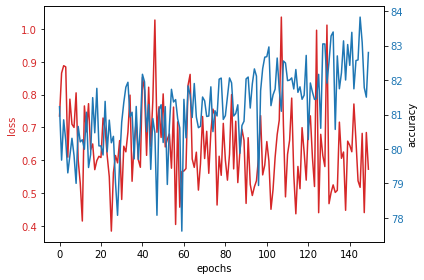

CPU times: user 27min 9s, sys: 7.47 s, total: 27min 17s
Wall time: 27min 19s


In [58]:
%%time
loss=fit_gpu(trainloader,150,net,op,loss_fn)

In [59]:
print(evaluation_gpu(trainloader),evaluation_gpu(testloader))

82.8 82.8


#Visualisation of images.

In [120]:
train_loader= torch.utils.data.DataLoader(testset,batch_size=5,shuffle=True)
dataiter=iter(train_loader)
images,labels = dataiter.next()
classes=testset.classes
net=net.to('cpu')

In [121]:
import numpy as np
def imshow(images):
  npimgs=images.numpy()
  npimg=np.transpose(npimgs,(1,2,0))
  plt.imshow(npimg)

Now, for the calculated parameters, we can now visualize output of each layer
by the given below methods.

In [152]:
net.cnn_net

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [153]:
net.fcc_net

Sequential(
  (0): Linear(in_features=400, out_features=120, bias=True)
  (1): ReLU()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): ReLU()
  (4): Linear(in_features=84, out_features=10, bias=True)
)

<Figure size 432x432 with 0 Axes>

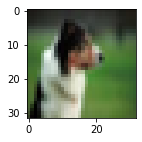

<Figure size 432x432 with 0 Axes>

In [157]:
out = net.cnn_net[1](images)            #applieng cnn_1(Linear(in_features=400, out_features=120, bias=True)) on images.|
out.shape
image_id = 4
plt.figure(figsize = (2,2))
imshow(images[image_id,])
plt.figure(figsize = (6,6))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


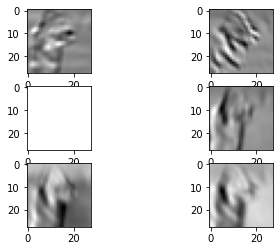

In [135]:
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()